In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv('./data/train_2327.csv')
data_test = pd.read_csv('./data/test_2327.csv')

In [21]:
#技術指標
#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#均價線
def AVL(df):#, tick_N):
    AVL =  pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index, columns = ['AVL'])  
    AVL['AVL'] = np.cumsum(df['DealPrice']*df['DealQty']) / np.cumsum(df['DealQty'])
    AVL['%AVL'] = df['mid1'] / AVL['AVL'] - 1
    return AVL

#布林通道
def BBANDS(df, n, multiple, tick_N):  
    MA = df.rolling(n).mean()
    #%change
    MA_ = MA / MA.shift(tick_N) -1
    MSD = df.rolling(n).std()
    ub1 =  MA + multiple * MSD
    #%change
    ub1_ = ub1 / ub1.shift(tick_N) -1
    uB1 = pd.DataFrame(ub1_, index = df.index, columns = df.columns)  
    lb1 =  MA - multiple * MSD
    #%change
    lb1_ = lb1 / lb1.shift(tick_N) -1
    lB1 = pd.DataFrame(lb1_, index = df.index, columns = df.columns)  
    b2 = (df - MA + multiple * MSD) / (2 * multiple * MSD)  
    B2 = pd.DataFrame(b2, index = df.index, columns = df.columns)  
    BBAND = pd.concat([uB1, lB1, B2], keys = ['UpperBand', 'LowerBand', '%B'], axis = 1)
    BBAND.columns = ['UpperBand', 'LowerBand', '%B']
    return BBAND

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow, C_price_name='mid1'):   
    EMAfast = df[C_price_name].ewm(span = n_fast, min_periods = n_slow - 1).mean() 
    EMAslow = df[C_price_name].ewm(span = n_slow, min_periods = n_slow - 1).mean() 
    #短EMA-長EMA
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(MACD.ewm(span = 9, min_periods = 8).mean(), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    MACD = pd.concat([MACD, MACDsign, MACDdiff], axis = 1)
    return MACD

#generate features
def AlphaGenerate_Tick(original_data,bb=False,avl=False,spread=False,macd=False,price_diff=False,
                       price_mean=False,qty_mean=False,acc_diff=False,dt1p=False,dt5p=False,dt10p=False,
                      cross1=False,cross5=False,cross10=False,spread_pq=False,price_diff_pq=False,
                      spread_pct_pq=False,pq_mean=False,acc_diff_pq=False,dt1_pq=False,dt5_pq=False,dt10_pq=False,
                      ma=False,dt1q=False,dt5q=False,dt10q=False):
    ############################################################################################################################
    #需要預先處裡的東西放這邊
    #build Date column
    #original_data['Date'] = pd.to_datetime(original_data['TxTime'])
    #original_data['Date'] = [str(x)[0:10] for x in original_data['Date']]
    #df to save X
    X = pd.DataFrame()
    #copy
    data=original_data.copy()
    #mid
    data['mid1'] = (data['Ask1'] + data['Bid1']) / 2
    data['mid2'] = (data['Ask2'] + data['Bid2']) / 2
    data['mid3'] = (data['Ask3'] + data['Bid3']) / 2
    data['mid4'] = (data['Ask4'] + data['Bid4']) / 2
    data['mid5'] = (data['Ask5'] + data['Bid5']) / 2
    #some index's ask1 = 0, we change that mid1 to bid1
    idx = data[data['Ask1'] == 0].index
    for i in idx:
        data['mid1'].iloc[i] = data['Bid1'].iloc[i]
    #委買委賣比，判斷買賣邊力道
    data['Ask1_value'] = data['AskQty1']/(data['BidQty1']+data['AskQty1'])
    data['Ask2_value'] = data['AskQty2']/(data['BidQty2']+data['AskQty2'])
    data['Ask3_value'] = data['AskQty3']/(data['BidQty3']+data['AskQty3'])
    data['Ask4_value'] = data['AskQty4']/(data['BidQty4']+data['AskQty4'])
    data['Ask5_value'] = data['AskQty5']/(data['BidQty5']+data['AskQty5'])
    data['Bid1_value'] = data['BidQty1']/(data['BidQty1']+data['AskQty1'])
    data['Bid2_value'] = data['BidQty2']/(data['BidQty2']+data['AskQty2'])
    data['Bid3_value'] = data['BidQty3']/(data['BidQty3']+data['AskQty3'])
    data['Bid4_value'] = data['BidQty4']/(data['BidQty4']+data['AskQty4'])
    data['Bid5_value'] = data['BidQty5']/(data['BidQty5']+data['AskQty5'])
    #ask and askqty <-> bid and bidqty if one side = 0
    data['Ask1'][data['Ask1']==0]=data['Bid1']
    data['Ask2'][data['Ask2']==0]=data['Bid2']
    data['Ask3'][data['Ask3']==0]=data['Bid3']
    data['Ask4'][data['Ask4']==0]=data['Bid4']
    data['Ask5'][data['Ask5']==0]=data['Bid5']
    data['AskQty1'][data['AskQty1']==0]=data['BidQty1']
    data['AskQty2'][data['AskQty2']==0]=data['BidQty2']
    data['AskQty3'][data['AskQty3']==0]=data['BidQty3']
    data['AskQty4'][data['AskQty4']==0]=data['BidQty4']
    data['AskQty5'][data['AskQty5']==0]=data['BidQty5']
    data['Bid1'][data['Bid1']==0]=data['Ask1']
    data['Bid2'][data['Bid2']==0]=data['Ask2']
    data['Bid3'][data['Bid3']==0]=data['Ask3']
    data['Bid4'][data['Bid4']==0]=data['Ask4']
    data['Bid5'][data['Bid5']==0]=data['Ask5']
    data['BidQty1'][data['BidQty1']==0]=data['AskQty1']
    data['BidQty2'][data['BidQty2']==0]=data['AskQty2']
    data['BidQty3'][data['BidQty3']==0]=data['AskQty3']
    data['BidQty4'][data['BidQty4']==0]=data['AskQty4']
    data['BidQty5'][data['BidQty5']==0]=data['AskQty5']
    #df to save
    #df_date = pd.DataFrame()
    #date_idx = data['Date'].unique()
    #value(price*quantity)
    #data['Ask1_value'] = data['Ask1']*data['AskQty1']
    #data['Ask2_value'] = data['Ask2']*data['AskQty2']
    #data['Ask3_value'] = data['Ask3']*data['AskQty3']
    #data['Ask4_value'] = data['Ask4']*data['AskQty4']
    #data['Ask5_value'] = data['Ask5']*data['AskQty5']
    #data['Bid1_value'] = data['Bid1']*data['BidQty1']
    #data['Bid2_value'] = data['Bid2']*data['BidQty2']
    #data['Bid3_value'] = data['Bid3']*data['BidQty3']
    #data['Bid4_value'] = data['Bid4']*data['BidQty4']
    #data['Bid5_value'] = data['Bid5']*data['BidQty5']
    ############################################################################################################################
    #因子放這邊
    #不用考慮換日的因子 
    #MA
    if ma == True:
        X['MA50_ask1']=MA(data['Ask1_value'], 50)-data['Ask1_value']
        X['MA50_ask2']=MA(data['Ask2_value'], 50)-data['Ask2_value']
        X['MA50_ask3']=MA(data['Ask3_value'], 50)-data['Ask3_value']
        X['MA50_ask4']=MA(data['Ask4_value'], 50)-data['Ask4_value']
        X['MA50_ask5']=MA(data['Ask5_value'], 50)-data['Ask5_value']
        X['MA50_bid1']=MA(data['Bid1_value'], 50)-data['Bid1_value']
        X['MA50_bid2']=MA(data['Bid2_value'], 50)-data['Bid2_value']
        X['MA50_bid3']=MA(data['Bid3_value'], 50)-data['Bid3_value']
        X['MA50_bid4']=MA(data['Bid4_value'], 50)-data['Bid4_value']
        X['MA50_bid5']=MA(data['Bid5_value'], 50)-data['Bid5_value']
        X['MA100_ask1']=MA(data['Ask1_value'], 100)-data['Ask1_value']
        X['MA100_ask2']=MA(data['Ask2_value'], 100)-data['Ask2_value']
        X['MA100_ask3']=MA(data['Ask3_value'], 100)-data['Ask3_value']
        X['MA100_ask4']=MA(data['Ask4_value'], 100)-data['Ask4_value']
        X['MA100_ask5']=MA(data['Ask5_value'], 100)-data['Ask5_value']
        X['MA100_bid1']=MA(data['Bid1_value'], 100)-data['Bid1_value']
        X['MA100_bid2']=MA(data['Bid2_value'], 100)-data['Bid2_value']
        X['MA100_bid3']=MA(data['Bid3_value'], 100)-data['Bid3_value']
        X['MA100_bid4']=MA(data['Bid4_value'], 100)-data['Bid4_value']
        X['MA100_bid5']=MA(data['Bid5_value'], 100)-data['Bid5_value']
        X['MA10_ab1']=MA(data['Ask1_value'], 10) - MA(data['Bid1_value'], 10)
        X['MA10_ab2']=MA(data['Ask2_value'], 10) - MA(data['Bid2_value'], 10)
        X['MA10_ab3']=MA(data['Ask3_value'], 10) - MA(data['Bid3_value'], 10)
        X['MA10_ab4']=MA(data['Ask4_value'], 10) - MA(data['Bid4_value'], 10)
        X['MA10_ab5']=MA(data['Ask5_value'], 10) - MA(data['Bid5_value'], 10)
        X['MA20_ab1']=MA(data['Ask1_value'], 20) - MA(data['Bid1_value'], 20)
        X['MA20_ab2']=MA(data['Ask2_value'], 20) - MA(data['Bid2_value'], 20)
        X['MA20_ab3']=MA(data['Ask3_value'], 20) - MA(data['Bid3_value'], 20)
        X['MA20_ab4']=MA(data['Ask4_value'], 20) - MA(data['Bid4_value'], 20)
        X['MA20_ab5']=MA(data['Ask5_value'], 20) - MA(data['Bid5_value'], 20)
        X['MA30_ab1']=MA(data['Ask1_value'], 30) - MA(data['Bid1_value'], 30)
        X['MA30_ab2']=MA(data['Ask2_value'], 30) - MA(data['Bid2_value'], 30)
        X['MA30_ab3']=MA(data['Ask3_value'], 30) - MA(data['Bid3_value'], 30)
        X['MA30_ab4']=MA(data['Ask4_value'], 30) - MA(data['Bid4_value'], 30)
        X['MA30_ab5']=MA(data['Ask5_value'], 30) - MA(data['Bid5_value'], 30)
        X['MA50_ab1']=MA(data['Ask1_value'], 50) - MA(data['Bid1_value'], 50)
        X['MA50_ab2']=MA(data['Ask2_value'], 50) - MA(data['Bid2_value'], 50)
        X['MA50_ab3']=MA(data['Ask3_value'], 50) - MA(data['Bid3_value'], 50)
        X['MA50_ab4']=MA(data['Ask4_value'], 50) - MA(data['Bid4_value'], 50)
        X['MA50_ab5']=MA(data['Ask5_value'], 50) - MA(data['Bid5_value'], 50)
        X['MA100_ab1']=MA(data['Ask1_value'], 100) - MA(data['Bid1_value'], 100)
        X['MA100_ab2']=MA(data['Ask2_value'], 100) - MA(data['Bid2_value'], 100)
        X['MA100_ab3']=MA(data['Ask3_value'], 100) - MA(data['Bid3_value'], 100)
        X['MA100_ab4']=MA(data['Ask4_value'], 100) - MA(data['Bid4_value'], 100)
        X['MA100_ab5']=MA(data['Ask5_value'], 100) - MA(data['Bid5_value'], 100)
    #布林通道
    if bb == True:
        X = pd.concat([X, BBANDS(data[['mid1']], 100, 5, 10)], axis = 1)
    #均價線
    if avl == True:
        X = pd.concat([X, AVL(data)], axis = 1)
    #MACD
    if macd == True:
        X = pd.concat([X, MACD(data, 12, 26, C_price_name='mid1')], axis = 1)
    #spread of price
    if spread == True:
        X['spread1'] = data['Ask1'] - data['Bid1']
        X['spread2'] = data['Ask2'] - data['Bid2']
        X['spread3'] = data['Ask3'] - data['Bid3']
        X['spread4'] = data['Ask4'] - data['Bid4']
        X['spread5'] = data['Ask5'] - data['Bid5']
    #pct change of value
    #if spread_pct_pq == True:
    #    X['spread1_pct_pq'] = (data['Ask1_value'] / data['Bid1_value']) -1
    #    X['spread2_pct_pq'] = (data['Ask2_value'] / data['Bid2_value']) -1
    #    X['spread3_pct_pq'] = (data['Ask3_value'] / data['Bid3_value']) -1
    #    X['spread4_pct_pq'] = (data['Ask4_value'] / data['Bid4_value']) -1
    #    X['spread5_pct_pq'] = (data['Ask5_value'] / data['Bid5_value']) -1
    #spread of value
    if spread_pq == True:
        X['spread1_pq'] = data['Ask1_value'] - data['Bid1_value']
        X['spread2_pq'] = data['Ask2_value'] - data['Bid2_value'] 
        X['spread3_pq'] = data['Ask3_value'] - data['Bid3_value'] 
        X['spread4_pq'] = data['Ask4_value'] - data['Bid4_value'] 
        X['spread5_pq'] = data['Ask5_value'] - data['Bid5_value'] 
    #price diff
    if price_diff == True:
        X['a51_diff'] = data['Ask5'] - data['Ask1']
        X['b15_diff'] = data['Bid1'] - data['Bid5']
        X['a21_diff_abs'] = np.abs(data['Ask2'] - data['Ask1'])
        X['a32_diff_abs'] = np.abs(data['Ask3'] - data['Ask2'])
        X['a43_diff_abs'] = np.abs(data['Ask4'] - data['Ask3'])
        X['a54_diff_abs'] = np.abs(data['Ask5'] - data['Ask4'])
        X['b21_diff_abs'] = np.abs(data['Bid2'] - data['Bid1'])
        X['b32_diff_abs'] = np.abs(data['Bid3'] - data['Bid2'])
        X['b43_diff_abs'] = np.abs(data['Bid4'] - data['Bid3'])
        X['b54_diff_abs'] = np.abs(data['Bid5'] - data['Bid4'])
    #value diff
    if price_diff_pq == True:
        X['a51_diff_pq'] = data['Ask5_value'] - data['Ask1_value']
        X['b15_diff_pq'] = data['Bid1_value'] - data['Bid5_value']
        X['a21_diff_pq'] = data['Ask2_value'] - data['Ask1_value']
        X['a32_diff_pq'] = data['Ask3_value'] - data['Ask2_value']
        X['a43_diff_pq'] = data['Ask4_value'] - data['Ask3_value']
        X['a54_diff_pq'] = data['Ask5_value'] - data['Ask4_value']
        X['b21_diff_pq'] = data['Bid2_value'] - data['Bid1_value']
        X['b32_diff_pq'] = data['Bid3_value'] - data['Bid2_value']
        X['b43_diff_pq'] = data['Bid4_value'] - data['Bid3_value']
        X['b54_diff_pq'] = data['Bid5_value'] - data['Bid4_value']
    #price mean
    if price_mean == True:
        X['a_mean'] = (data['Ask1'] +data['Ask2'] +data['Ask3'] +data['Ask4'] +data['Ask5']) / 5
        X['b_mean'] = (data['Bid1'] +data['Bid2'] +data['Bid3'] +data['Bid4'] +data['Bid5']) / 5
    #quantity mean
    if qty_mean == True:
        X['aq_mean'] = (data['AskQty1'] +data['AskQty2'] +data['AskQty3'] +data['AskQty4'] +data['AskQty5']) / 5
        X['bq_mean'] = (data['BidQty1'] +data['BidQty2'] +data['BidQty3'] +data['BidQty4'] +data['BidQty5']) / 5
    #value mean
    if pq_mean == True:
        X['a_pq_mean'] = (data['Ask1_value']+data['Ask2_value']+data['Ask3_value']+data['Ask4_value']+data['Ask5_value'])/5
        X['b_pq_mean'] = (data['Bid1_value']+data['Bid2_value']+data['Bid3_value']+data['Bid4_value']+data['Bid5_value'])/5
    #accumulative difference of price and quantity
    if acc_diff == True:
        X['p_acc_diff'] = (data['Ask1'] - data['Bid1']) +(data['Ask2'] - data['Bid2']) + (data['Ask3'] - data['Bid3']) + (data['Ask4'] - data['Bid4']) + (data['Ask5'] - data['Bid5'])
        X['q_acc_diff'] = (data['AskQty1'] - data['BidQty1']) +(data['AskQty2'] - data['BidQty2']) + (data['AskQty3'] - data['BidQty3']) + (data['AskQty4'] - data['BidQty4']) + (data['AskQty5'] - data['BidQty5'])
    #value accumulative difference
    if acc_diff_pq == True:
        X['p_acc_diff_pq'] = (data['Ask1_value'] - data['Bid1_value']) +(data['Ask2_value'] - data['Bid2_value']) + (data['Ask3_value'] - data['Bid3_value']) + (data['Ask4_value'] - data['Bid4_value']) + (data['Ask5_value'] - data['Bid5_value'])
    ############################################################################################################################
    #要考慮換日的因子
    #shift 1 5 10 (price, quantity, value)
    if dt1p == True:
    #1 tick
        X['da1_dt_1'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(1)
        X['da2_dt_1'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(1)
        X['da3_dt_1'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(1)
        X['da4_dt_1'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(1)
        X['da5_dt_1'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(1)
        X['db1_dt_1'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(1)
        X['db2_dt_1'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(1)
        X['db3_dt_1'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(1)
        X['db4_dt_1'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(1)
        X['db5_dt_1'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(1)
        #fillna to 0
        X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']] = X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']].fillna(value = 0)
        
    if dt1_pq == True:
    #1 tick
        X['da1_dt_1_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(1)
        X['da2_dt_1_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(1)
        X['da3_dt_1_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(1)
        X['da4_dt_1_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(1)
        X['da5_dt_1_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(1)
        X['db1_dt_1_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(1)
        X['db2_dt_1_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(1)
        X['db3_dt_1_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(1)
        X['db4_dt_1_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(1)
        X['db5_dt_1_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(1)
    if dt5p == True:
    #5 ticks
        X['da1_dt_5'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(5)
        X['da2_dt_5'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(5)
        X['da3_dt_5'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(5)
        X['da4_dt_5'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(5)
        X['da5_dt_5'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(5)
        X['db1_dt_5'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(5)
        X['db2_dt_5'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(5)
        X['db3_dt_5'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(5)
        X['db4_dt_5'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(5)
        X['db5_dt_5'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(5)
        #fill na to 0
        X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']] = X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']].fillna(value = 0)
    if dt5_pq == True:
    #5 tick
        X['da1_dt_5_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(5)
        X['da2_dt_5_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(5)
        X['da3_dt_5_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(5)
        X['da4_dt_5_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(5)
        X['da5_dt_5_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(5)
        X['db1_dt_5_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(5)
        X['db2_dt_5_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(5)
        X['db3_dt_5_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(5)
        X['db4_dt_5_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(5)
        X['db5_dt_5_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(5)                                            
    if dt10p == True:
    #10 ticks
        X['da1_dt_10'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(10)
        X['da2_dt_10'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(10)
        X['da3_dt_10'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(10)
        X['da4_dt_10'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(10)
        X['da5_dt_10'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(10)
        X['db1_dt_10'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(10)
        X['db2_dt_10'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(10)
        X['db3_dt_10'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(10)
        X['db4_dt_10'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(10)
        X['db5_dt_10'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(10)
        #fill na to 0
        X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']] = X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']].fillna(value = 0)
    if dt10_pq == True:
    #10 tick
        X['da1_dt_10_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(10)
        X['da2_dt_10_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(10)
        X['da3_dt_10_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(10)
        X['da4_dt_10_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(10)
        X['da5_dt_10_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(10)
        X['db1_dt_10_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(10)
        X['db2_dt_10_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(10)
        X['db3_dt_10_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(10)
        X['db4_dt_10_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(10)
        X['db5_dt_10_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(10)                                           
    #quantity
    if dt1q == True:
    #1 tick
        X['daq1_dt_1'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(1)
        X['daq2_dt_1'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(1)
        X['daq3_dt_1'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(1)
        X['daq4_dt_1'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(1)
        X['daq5_dt_1'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(1)
        X['dbq1_dt_1'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(1)
        X['dbq2_dt_1'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(1)
        X['dbq3_dt_1'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(1)
        X['dbq4_dt_1'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(1)
        X['dbq5_dt_1'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(1)
        #fill na to 0
        X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']] = X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']].fillna(value = 0)
    if dt5q == True:
    #5 ticks
        X['daq1_dt_5'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(5)
        X['daq2_dt_5'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(5)
        X['daq3_dt_5'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(5)
        X['daq4_dt_5'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(5)
        X['daq5_dt_5'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(5)
        X['dbq1_dt_5'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(5)
        X['dbq2_dt_5'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(5)
        X['dbq3_dt_5'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(5)
        X['dbq4_dt_5'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(5)
        X['dbq5_dt_5'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(5)
        #fill na to 0
        X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']] = X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']].fillna(value = 0)
    if dt10q == True:
    #10 ticks
        X['daq1_dt_10'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(10)
        X['daq2_dt_10'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(10)
        X['daq3_dt_10'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(10)
        X['daq4_dt_10'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(10)
        X['daq5_dt_10'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(10)
        X['dbq1_dt_10'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(10)
        X['dbq2_dt_10'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(10)
        X['dbq3_dt_10'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(10)
        X['dbq4_dt_10'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(10)
        X['dbq5_dt_10'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(10)
        #fill na to 0
        X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']] = X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']].fillna(value = 0)    
    #features crosses
    #dt1
    if (cross1 == True) and (dt1p == True) and (dt1q == True):
        #ask
        X['aq1dt1_cross'] = X['da1_dt_1'] * X['daq1_dt_1']
        X['aq2dt1_cross'] = X['da2_dt_1'] * X['daq2_dt_1']
        X['aq3dt1_cross'] = X['da3_dt_1'] * X['daq3_dt_1']
        X['aq4dt1_cross'] = X['da4_dt_1'] * X['daq4_dt_1']
        X['aq5dt1_cross'] = X['da5_dt_1'] * X['daq5_dt_1']
        #bid
        X['bq1dt1_cross'] = X['db1_dt_1'] * X['dbq1_dt_1']
        X['bq2dt1_cross'] = X['db2_dt_1'] * X['dbq2_dt_1']
        X['bq3dt1_cross'] = X['db3_dt_1'] * X['dbq3_dt_1']
        X['bq4dt1_cross'] = X['db4_dt_1'] * X['dbq4_dt_1']
        X['bq5dt1_cross'] = X['db5_dt_1'] * X['dbq5_dt_1']
    #dt5
    if (cross5 == True) and (dt5p == True) and (dt5q == True):
        #ask
        X['aq1dt5_cross'] = X['da1_dt_5'] * X['daq1_dt_5']
        X['aq2dt5_cross'] = X['da2_dt_5'] * X['daq2_dt_5']
        X['aq3dt5_cross'] = X['da3_dt_5'] * X['daq3_dt_5']
        X['aq4dt5_cross'] = X['da4_dt_5'] * X['daq4_dt_5']
        X['aq5dt5_cross'] = X['da5_dt_5'] * X['daq5_dt_5']
        #bid
        X['bq1dt5_cross'] = X['db1_dt_5'] * X['dbq1_dt_5']
        X['bq2dt5_cross'] = X['db2_dt_5'] * X['dbq2_dt_5']
        X['bq3dt5_cross'] = X['db3_dt_5'] * X['dbq3_dt_5']
        X['bq4dt5_cross'] = X['db4_dt_5'] * X['dbq4_dt_5']
        X['bq5dt5_cross'] = X['db5_dt_5'] * X['dbq5_dt_5']
    #dt10
    if (cross10 == True) and (dt10p == True) and (dt10q == True):
        #ask
        X['aq1dt10_cross'] = X['da1_dt_10'] * X['daq1_dt_10']
        X['aq2dt10_cross'] = X['da2_dt_10'] * X['daq2_dt_10']
        X['aq3dt10_cross'] = X['da3_dt_10'] * X['daq3_dt_10']
        X['aq4dt10_cross'] = X['da4_dt_10'] * X['daq4_dt_10']
        X['aq5dt10_cross'] = X['da5_dt_10'] * X['daq5_dt_10']
        #bid
        X['bq1dt10_cross'] = X['db1_dt_10'] * X['dbq1_dt_10']
        X['bq2dt10_cross'] = X['db2_dt_10'] * X['dbq2_dt_10']
        X['bq3dt10_cross'] = X['db3_dt_10'] * X['dbq3_dt_10']
        X['bq4dt10_cross'] = X['db4_dt_10'] * X['dbq4_dt_10']
        X['bq5dt10_cross'] = X['db5_dt_10'] * X['dbq5_dt_10']
    df = pd.concat([data, X], axis = 1)
    df = df.dropna()
    df = df.reset_index(drop = True)
    X = X.dropna()
    X = X.reset_index(drop = True)
    return X, df

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

#strategy
def strategy(df_train, paras):
    #adding hard stop 
    #main strategy (train set)
    #record transaction
    transaction_history1 = {}
    #record equity values
    equity_value_1 = pd.DataFrame()
    #record each returns
    #each_return1 = pd.DataFrame()
    #record unrealized gain
    unrealized_1 = pd.DataFrame()
    for l in range(len(paras)):
        df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
        for j in range(len(df_train)):
            if df_train['pred_return'].iloc[j] > paras[l][0]:
                #long side
                df_train['side'].iloc[j] = 1
            elif df_train['pred_return'].iloc[j] < paras[l][1]:
                #short side
                df_train['side'].iloc[j] = -1
        date_idx = df_train['Date'].unique()
        #紀錄已實現
        equity_value1 = pd.DataFrame()
        #紀錄未實現
        unrealized1 = pd.DataFrame()
        for k in date_idx:
            df = df_train[df_train.Date == k]
            #side = 0
            for i in range(len(df)):
                #first tick
                if i == 0:
                    #ask1 may be 0, which means 漲停 (買不到)
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        #side = 1
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                        side = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                    elif df['side'].iloc[i] == -1:
                        #side = -1
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        #side = 0
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                #last tick
                elif i == (len(df) - 1):
                    if df['holding'].iloc[i-1] == 1:
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #ask1 may be 0, which means 漲停 (買不到)
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #收盤如果漲停，空單結不掉，先用mid1結
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                        df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    else:
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                else:
                    if df['holding'].iloc[i-1] == 1:
                        #hard stop 1 -1 = 0 -> 0
                        if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side 1 -2 -> -1
                        elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - (0.0015 * 2) 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                    elif df['holding'].iloc[i-1] == -1:
                        #hard stop -1 +1 -> 0
                        if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side -1 +2 -> 1
                        elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    elif df['holding'].iloc[i-1] == 0:
                        if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        elif df['side'].iloc[i] == -1:
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = - 0.0015
                            df['unrealized'].iloc[i] = -0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
            equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
            #if k == date_idx[0]:
            unrealized1 = pd.concat([unrealized1, df[['unrealized']]])
            #else:
            #    unrealized_1 = pd.concat([unrealized_1, df['unrealized'] + unrealized_1.iloc[len(unrealized_1) - 1]])
        #concat
        equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
        #each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    
        unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)
    return equity_value_1, unrealized_1, transaction_history1

#unrealized return
def unrealized(equity_value_1, unrealized_1):
    idx = []
    for i in range(len(equity_value_1) - 1):
        if (equity_value_1.iloc[i] != equity_value_1.iloc[i+1]) and (equity_value_1.iloc[i+1] != -0.0015):
            idx.append(i+1)
    unrealized_return = pd.DataFrame()
    for i in range(len(idx)):
        if i == 0:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[:idx[i]])])
        else:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[idx[i-1]:idx[i]])])
    return unrealized_return

In [22]:
data_train['Date'] = pd.to_datetime(data_train['TxTime'])
data_train['Date'] = [str(x)[0:10] for x in data_train['Date']]
data_test['Date'] = pd.to_datetime(data_test['TxTime'])
data_test['Date'] = [str(x)[0:10] for x in data_test['Date']]

In [23]:
X_in, data_train1 = AlphaGenerate_Tick(data_train,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,bb=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user

In [24]:
#test set
X_out, data_test1 = AlphaGenerate_Tick(data_test,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,bb=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [25]:
X_in

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,daq1_dt_10,daq2_dt_10,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10
0,-0.067116,-0.033137,0.277637,-0.336567,0.241052,0.067116,0.033137,-0.277637,0.336567,-0.241052,...,10.0,3.0,-16.0,23.0,-1.0,-13.0,0.0,0.0,0.0,1.0
1,-0.102501,-0.027416,0.271351,-0.324047,0.223716,0.102501,0.027416,-0.271351,0.324047,-0.223716,...,14.0,3.0,-16.0,23.0,-1.0,10.0,0.0,0.0,0.0,1.0
2,-0.096479,-0.032863,0.265065,-0.311528,0.206381,0.096479,0.032863,-0.265065,0.311528,-0.206381,...,14.0,4.0,-16.0,23.0,-1.0,9.0,0.0,0.0,0.0,0.0
3,0.323223,0.023585,-0.077221,0.209903,-0.114248,-0.323223,-0.023585,0.077221,-0.209903,0.114248,...,1.0,-1.0,-1.0,-14.0,37.0,9.0,0.0,0.0,0.0,1.0
4,0.389402,0.471634,-0.018843,-0.123963,0.166719,-0.389402,-0.471634,0.018843,0.123963,-0.166719,...,-15.0,-18.0,-3.0,15.0,-37.0,-1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736250,-0.003801,0.028831,0.011299,0.001452,0.003457,0.003801,-0.028831,-0.011299,-0.001452,-0.003457,...,9.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
736251,0.003087,0.027964,0.010779,0.001402,0.003326,-0.003087,-0.027964,-0.010779,-0.001402,-0.003326,...,9.0,0.0,-1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
736252,0.004432,0.027097,0.005350,0.001352,0.003195,-0.004432,-0.027097,-0.005350,-0.001352,-0.003195,...,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
736253,0.004540,0.022686,0.005028,0.001302,0.003063,-0.004540,-0.022686,-0.005028,-0.001302,-0.003063,...,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0


In [26]:
X_out

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,daq1_dt_10,daq2_dt_10,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10
0,0.174190,-0.138221,0.150769,-0.048910,0.342545,-0.174190,0.138221,-0.150769,0.048910,-0.342545,...,5.0,0.0,0.0,0.0,0.0,30.0,-12.0,27.0,-36.0,101.0
1,0.153036,-0.134888,0.147692,-0.047921,0.335359,-0.153036,0.134888,-0.147692,0.047921,-0.335359,...,0.0,0.0,0.0,0.0,0.0,27.0,-12.0,27.0,-36.0,101.0
2,0.150036,-0.243555,0.144615,-0.046932,0.328174,-0.150036,0.243555,-0.144615,0.046932,-0.328174,...,0.0,8.0,0.0,0.0,0.0,28.0,-12.0,27.0,-36.0,101.0
3,-0.143033,-0.208899,-0.009231,0.002503,-0.025213,0.143033,0.208899,0.009231,-0.002503,0.025213,...,0.0,8.0,0.0,0.0,0.0,-2.0,-8.0,0.0,-1.0,-1.0
4,-0.152687,-0.203872,-0.009231,0.002503,-0.025333,0.152687,0.203872,0.009231,-0.002503,0.025333,...,1.0,8.0,0.0,0.0,0.0,73.0,-8.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337386,-0.287004,0.245861,-0.032353,-0.042980,-0.086593,0.287004,-0.245861,0.032353,0.042980,0.086593,...,71.0,-49.0,7.0,8.0,21.0,-5.0,0.0,0.0,0.0,0.0
337387,-0.906202,0.509414,-0.233356,0.239099,-0.448099,0.906202,-0.509414,0.233356,-0.239099,0.448099,...,73.0,-49.0,7.0,8.0,21.0,-141.0,103.0,-48.0,57.0,-94.0
337388,-0.263279,0.230795,-0.027309,-0.047203,-0.075645,0.263279,-0.230795,0.027309,0.047203,0.075645,...,72.0,-49.0,7.0,6.0,21.0,-5.0,0.0,0.0,0.0,0.0
337389,0.074161,-0.015117,0.018449,-0.006843,0.012715,-0.074161,0.015117,-0.018449,0.006843,-0.012715,...,0.0,-3.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,0.0


In [27]:
train_pred_return = pd.read_csv('./data/train_2327_mix3.csv')
test_pred_return  = pd.read_csv('./data/test_2327_mix3.csv')

In [28]:
train_pred_return = train_pred_return.drop(['Unnamed: 0'], axis = 1)
train_pred_return.columns = ['pred_return']
train_pred_return

,pred_return
0,0.000683
1,0.000891
2,0.001654
3,0.002188
4,0.002200
...,...
736240,0.000304
736241,0.000241
736242,0.000166
736243,0.000151


In [29]:
test_pred_return = test_pred_return.drop(['Unnamed: 0'], axis = 1)
test_pred_return.columns = ['pred_return']
test_pred_return

,pred_return
0,-0.000005
1,0.000063
2,0.000038
3,0.000108
4,0.000144
...,...
337376,0.000304
337377,0.000180
337378,0.000021
337379,0.000062


In [30]:
df_train = X_in.iloc[10:]
df_train = df_train.reset_index(drop = True)
df_train = pd.concat([df_train, train_pred_return], axis = 1)
df_train['Date'] = data_train1['Date'].iloc[10:].values
df_train['Ask1'] = data_train1['Ask1'].iloc[10:].values
df_train['Bid1'] = data_train1['Bid1'].iloc[10:].values
df_train['mid1'] = data_train1['mid1'].iloc[10:].values

In [32]:
df_test = X_out.iloc[10:]
df_test = df_test.reset_index(drop = True)
df_test = pd.concat([df_test, test_pred_return], axis = 1)
df_test['Date'] = data_test1['Date'].iloc[10:].values
df_test['Ask1'] = data_test1['Ask1'].iloc[10:].values
df_test['Bid1'] = data_test1['Bid1'].iloc[10:].values
df_test['mid1'] = data_test1['mid1'].iloc[10:].values

In [33]:
#已實現損益
df_train['equity_value'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
#未實現損益
df_train['unrealized'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
df_train['holding'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])

In [34]:
#已實現損益
df_test['equity_value'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
#未實現損益
df_test['unrealized'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
df_test['holding'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])

In [35]:
df_train

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,dbq4_dt_10,dbq5_dt_10,pred_return,Date,Ask1,Bid1,mid1,equity_value,unrealized,holding
0,-0.448184,0.272519,0.111275,-0.245143,-0.004118,0.448184,-0.272519,-0.111275,0.245143,0.004118,...,-1.0,-56.0,0.000683,2020-03-23,238.5,238.0,238.25,0.0,0.0,0.0
1,0.396081,0.054988,-0.095321,0.312809,-0.214991,-0.396081,-0.054988,0.095321,-0.312809,0.214991,...,4.0,1.0,0.000891,2020-03-23,238.0,237.0,237.50,0.0,0.0,0.0
2,0.317831,0.055215,-0.089797,0.305286,-0.214216,-0.317831,-0.055215,0.089797,-0.305286,0.214216,...,4.0,1.0,0.001654,2020-03-23,238.0,237.0,237.50,0.0,0.0,0.0
3,0.268225,-0.010551,-0.084975,0.304443,-0.219157,-0.268225,0.010551,0.084975,-0.304443,0.219157,...,4.0,0.0,0.002188,2020-03-23,238.0,237.0,237.50,0.0,0.0,0.0
4,0.142068,0.231031,-0.225350,0.226919,-0.530887,-0.142068,-0.231031,0.225350,-0.226919,0.530887,...,0.0,-57.0,0.002200,2020-03-23,238.0,237.5,237.75,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736240,-0.003801,0.028831,0.011299,0.001452,0.003457,0.003801,-0.028831,-0.011299,-0.001452,-0.003457,...,1.0,0.0,0.000304,2020-04-23,345.0,344.5,344.75,0.0,0.0,0.0
736241,0.003087,0.027964,0.010779,0.001402,0.003326,-0.003087,-0.027964,-0.010779,-0.001402,-0.003326,...,1.0,0.0,0.000241,2020-04-23,345.0,344.5,344.75,0.0,0.0,0.0
736242,0.004432,0.027097,0.005350,0.001352,0.003195,-0.004432,-0.027097,-0.005350,-0.001352,-0.003195,...,1.0,0.0,0.000166,2020-04-23,345.0,344.5,344.75,0.0,0.0,0.0
736243,0.004540,0.022686,0.005028,0.001302,0.003063,-0.004540,-0.022686,-0.005028,-0.001302,-0.003063,...,1.0,0.0,0.000151,2020-04-23,345.0,344.5,344.75,0.0,0.0,0.0


In [36]:
df_test

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,dbq4_dt_10,dbq5_dt_10,pred_return,Date,Ask1,Bid1,mid1,equity_value,unrealized,holding
0,0.132454,-0.199788,0.109162,-0.040955,0.285542,-0.132454,0.199788,-0.109162,0.040955,-0.285542,...,0.0,0.0,-0.000005,2020-04-24,343.0,342.0,342.50,0.0,0.0,0.0
1,0.130012,-0.194169,0.082809,-0.039955,0.278477,-0.130012,0.194169,-0.082809,0.039955,-0.278477,...,0.0,0.0,0.000063,2020-04-24,343.0,342.0,342.50,0.0,0.0,0.0
2,0.130387,-0.188549,0.080566,-0.038955,0.271530,-0.130387,0.188549,-0.080566,0.038955,-0.271530,...,0.0,0.0,0.000038,2020-04-24,343.0,342.0,342.50,0.0,0.0,0.0
3,0.136854,-0.182930,0.078324,-0.037955,0.264583,-0.136854,0.182930,-0.078324,0.037955,-0.264583,...,-35.0,102.0,0.000108,2020-04-24,343.0,342.0,342.50,0.0,0.0,0.0
4,-0.159473,-0.162234,-0.037387,0.006280,-0.088566,0.159473,0.162234,0.037387,-0.006280,0.088566,...,-8.0,0.0,0.000144,2020-04-24,343.0,342.5,342.75,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337376,-0.287004,0.245861,-0.032353,-0.042980,-0.086593,0.287004,-0.245861,0.032353,0.042980,0.086593,...,0.0,0.0,0.000304,2020-05-05,411.0,410.0,410.50,0.0,0.0,0.0
337377,-0.906202,0.509414,-0.233356,0.239099,-0.448099,0.906202,-0.509414,0.233356,-0.239099,0.448099,...,57.0,-94.0,0.000180,2020-05-05,411.0,410.5,410.75,0.0,0.0,0.0
337378,-0.263279,0.230795,-0.027309,-0.047203,-0.075645,0.263279,-0.230795,0.027309,0.047203,0.075645,...,0.0,0.0,0.000021,2020-05-05,411.0,410.0,410.50,0.0,0.0,0.0
337379,0.074161,-0.015117,0.018449,-0.006843,0.012715,-0.074161,0.015117,-0.018449,0.006843,-0.012715,...,0.0,0.0,0.000062,2020-05-05,410.5,410.0,410.25,0.0,0.0,0.0


In [37]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002, 0.0025, 0.003], [-0.001, -0.0015, -0.002, -0.0025, -0.003], [-0.015, -0.02]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.0025, -0.015),
 (0.001, -0.0025, -0.02),
 (0.001, -0.003, -0.015),
 (0.001, -0.003, -0.02),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0015, -0.0025, -0.015),
 (0.0015, -0.0025, -0.02),
 (0.0015, -0.003, -0.015),
 (0.0015, -0.003, -0.02),
 (0.002, -0.001, -0.015),
 (0.002, -0.001, -0.02),
 (0.002, -0.0015, -0.015),
 (0.002, -0.0015, -0.02),
 (0.002, -0.002, -0.015),
 (0.002, -0.002, -0.02),
 (0.002, -0.0025, -0.015),
 (0.002, -0.0025, -0.02),
 (0.002, -0.003, -0.015),
 (0.002, -0.003, -0.02),
 (0.0025, -0.001, -0.015),
 (0.0025, -0.001, -0.02),
 (0.0025, -0.0015, -0.015),
 (0.0025, -0.0015, -0.02),
 (0.0025, -0.002, -0.015),
 (0.0025, -0.002, -0.02),
 (0.0025, -0.0025, -0.015),
 (0.0025, -0.0025, -0.02

In [38]:
equity_value_1, unrealized_1, transaction_history1 = strategy(df_train, paras)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

In [39]:
equity_value_1.columns = paras
unrealized_1.columns = paras
equity_value_1.iloc[-1]

(0.001, -0.001, -0.015)     -0.211358
(0.001, -0.001, -0.02)      -0.211358
(0.001, -0.0015, -0.015)     0.261228
(0.001, -0.0015, -0.02)      0.255774
(0.001, -0.002, -0.015)      0.266420
(0.001, -0.002, -0.02)       0.274186
(0.001, -0.0025, -0.015)     0.171586
(0.001, -0.0025, -0.02)      0.168296
(0.001, -0.003, -0.015)      0.182230
(0.001, -0.003, -0.02)       0.180930
(0.0015, -0.001, -0.015)     0.277660
(0.0015, -0.001, -0.02)      0.299212
(0.0015, -0.0015, -0.015)    0.406039
(0.0015, -0.0015, -0.02)     0.400653
(0.0015, -0.002, -0.015)     0.417233
(0.0015, -0.002, -0.02)      0.424018
(0.0015, -0.0025, -0.015)    0.297297
(0.0015, -0.0025, -0.02)     0.284492
(0.0015, -0.003, -0.015)     0.242725
(0.0015, -0.003, -0.02)      0.250140
(0.002, -0.001, -0.015)      0.110590
(0.002, -0.001, -0.02)       0.129458
(0.002, -0.0015, -0.015)     0.250951
(0.002, -0.0015, -0.02)      0.235901
(0.002, -0.002, -0.015)      0.370660
(0.002, -0.002, -0.02)       0.359844
(0.002, -0.0

In [40]:
performance(equity_value_1[[(0.0015, -0.0015, -0.015)]], transaction_history1[(0.0015, -0.0015, -0.015)])

return: 0.40603941238905894
std: 0.13430379587856167
sharp ratio: 2.9845724744183735
trades: 397.0
odds ratio: 0.4987405541561713
mdd: 0.11667971597541404
skewness: -0.5496689321339525


(0.40603941238905894,
 0.13430379587856167,
 2.9845724744183735,
 397.0,
 0.4987405541561713,
 0.11667971597541404,
 -0.5496689321339525)

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.,  700000.,  800000.]),
 <a list of 10 Text xticklabel objects>)

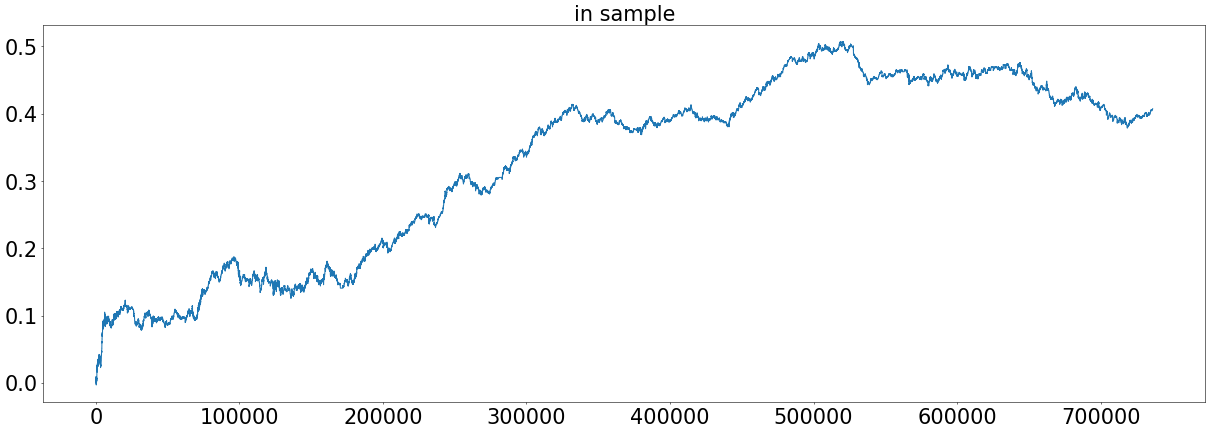

In [44]:
unrealized_return_train = unrealized(equity_value_1[(0.0015,-0.0015,-0.015)], unrealized_1[(0.0015,-0.0015,-0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [48]:
profit_col = [(0.0015, -0.0015, -0.015), (0.0015, -0.0015, -0.02), (0.0015, -0.002, -0.015), (0.0015, -0.002, -0.02)]
equity_value_2, unrealized_2, transaction_history2 = strategy(df_test, profit_col)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

In [49]:
equity_value_2.columns = profit_col
unrealized_2.columns = profit_col
equity_value_2.iloc[-1]

(0.0015, -0.0015, -0.015)   -0.042478
(0.0015, -0.0015, -0.02)    -0.042478
(0.0015, -0.002, -0.015)    -0.024445
(0.0015, -0.002, -0.02)     -0.025764
Name: 337380, dtype: float64

return: -0.042478053199011656
std: 0.022352300181923038
sharp ratio: -2.133026704677593
trades: 128.0
odds ratio: 0.3671875
mdd: 0.08576949515828308
skewness: -0.07286078983965188


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 <a list of 10 Text xticklabel objects>)

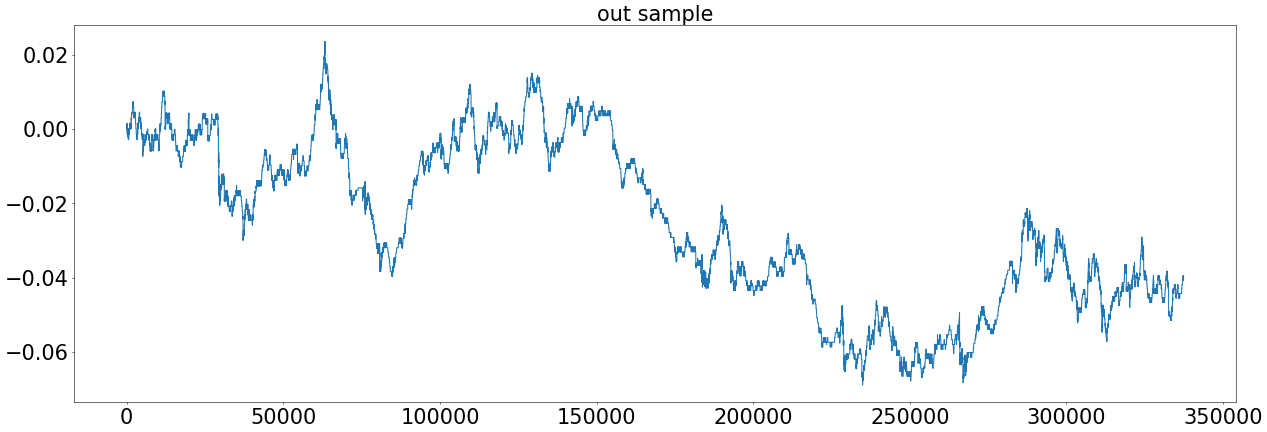

In [50]:
performance(equity_value_2[[(0.0015, -0.0015, -0.015)]], transaction_history2[(0.0015, -0.0015, -0.015)])
unrealized_return_test = unrealized(equity_value_2[(0.0015, -0.0015, -0.015)], unrealized_2[(0.0015, -0.0015, -0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)